In [1]:
%load_ext autoreload
%autoreload 2
%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

import pickle
import pandas as pd
import numpy as np
import json
import time
import argparse
from tqdm import tqdm

from framework import run_measurements, viz
from fracdiff import frac_diff_bestd
from monash_data_utils import convert_tsf_to_dataframe, monash_df_to_gluonts_train_datasets
import os


/mnt/c/Users/resha/Documents/Github/balancing_framework


/home/reshawn/miniconda3/envs/clfr/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def get_series(dataset_name, series_to_pull):
    dataset = None
    monash_dir = "monash_data"
    series_num = -1
    if os.path.exists(f"{monash_dir}/{dataset_name}.tsf"):
        loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe(f"{monash_dir}/{dataset_name}.tsf")
        if forecast_horizon is None: forecast_horizon = 24
        dataset = monash_df_to_gluonts_train_datasets(loaded_data, frequency, forecast_horizon)

    if dataset is None:
        if dataset_name in dataset_names:
            dataset = get_dataset(dataset_name)
        else:
            raise ValueError(f"Dataset {dataset_name} not found in gluonts availables or local monash files.")

    for entry in tqdm(dataset.test):
        series_num += 1
        if series_num > series_to_pull:
            break
        if series_num != series_to_pull:
            continue
        row = pd.Series(entry['target'])
    return row


In [4]:
london_row = get_series('london_smart_meters_without_missing', 867) # also 1610

 16%|█▌        | 868/5560 [00:06<00:37, 126.01it/s]


In [5]:
m4_row = get_series('m4_daily_dataset', 1165)

 28%|██▊       | 1166/4227 [00:00<00:00, 1742893.25it/s]


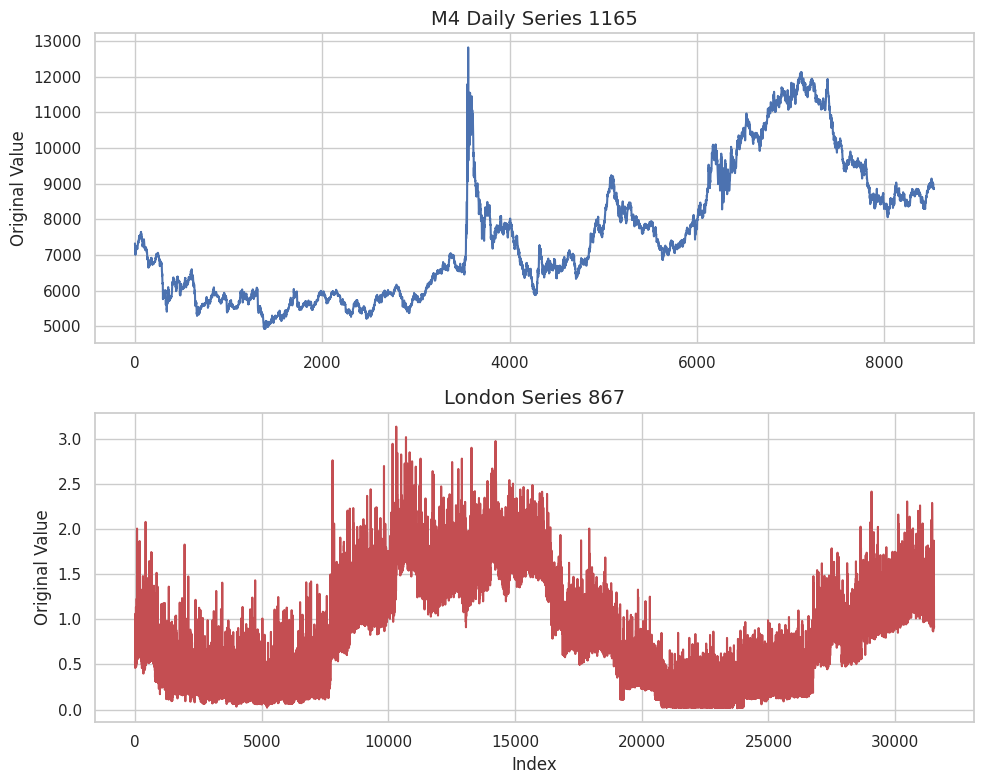

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure with two subplots, arranged vertically
# The sharex=True argument ensures both plots share the same x-axis for easier comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Plot the first series on the top subplot (ax1)
ax1.plot(m4_row,color='b')
ax1.set_title('M4 Daily Series 1165', fontsize=14)
ax1.set_ylabel('Original Value', fontsize=12)
ax1.grid(True)

# Plot the second series on the bottom subplot (ax2)
ax2.plot(london_row, color='r')
ax2.set_title('London Series 867', fontsize=14)
ax2.set_xlabel('Index', fontsize=12)
ax2.set_ylabel('Original Value', fontsize=12)
ax2.grid(True)

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.savefig(f'compare_series.png')

In [10]:
np.std(london_row)/london_row.mean()

0.7453920833916919

In [11]:
np.std(m4_row)/m4_row.mean()

0.24499482650728316

In [18]:
np.std(smoothed_series)/smoothed_series.mean()

0.700643633836233

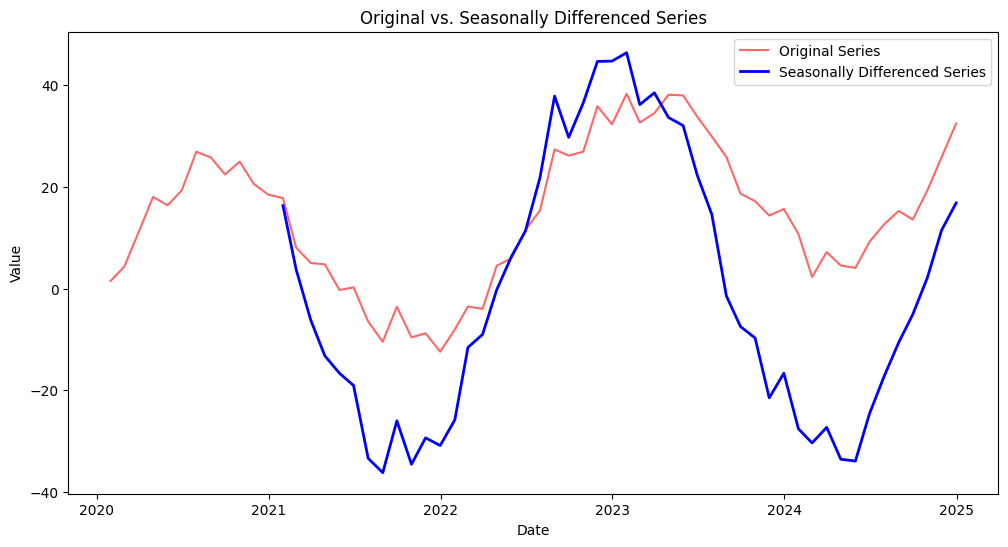

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Re-using the same series from above
np.random.seed(42)
index = pd.date_range('2020-01', periods=60, freq='M')
seasonal_component = 20 * np.sin(np.linspace(0, 4 * np.pi, 60))
trend_component = np.arange(60) * 0.5
noise = np.random.normal(0, 3, 60)
series = pd.Series(seasonal_component + trend_component + noise, index=index)

# Apply seasonal differencing with a period of 12 (for yearly seasonality)
seasonal_differenced_series = series.diff(periods=12)

# Plot both the original and differenced series for comparison
plt.figure(figsize=(12, 6))
plt.plot(series, label='Original Series', color='red', alpha=0.6)
plt.plot(seasonal_differenced_series, label='Seasonally Differenced Series', color='blue', linewidth=2)
plt.title('Original vs. Seasonally Differenced Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Checking of next fd conditions
long-term memory and absence of strong seasonality

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

def has_strong_seasonality(series: pd.Series, seasonal_period: int, threshold: float = 0.5) -> bool:
    """
    Checks if a time series has strong seasonality at a given period.

    Args:
        series (pd.Series): The input time series.
        seasonal_period (int): The number of data points in one seasonal cycle (e.g., 7 for weekly, 12 for monthly).
        threshold (float): The minimum absolute autocorrelation value to consider a seasonal pattern "strong".

    Returns:
        bool: True if strong seasonality is detected, False otherwise.
    """
    if len(series) < seasonal_period * 2:
        # Not enough data to check for at least two seasonal cycles
        return False
    
    # Calculate the ACF values and the confidence intervals
    # alpha=0.05 gives 95% confidence intervals
    acf_values, conf_int = acf(series, nlags=seasonal_period * 2, alpha=0.05)
    
    # Get the autocorrelation value at the seasonal lag
    seasonal_acf = acf_values[seasonal_period]
    
    # Check if the autocorrelation at the seasonal lag is statistically significant
    # The confidence interval is symmetrical around zero, so we just check against one side
    is_significant = abs(seasonal_acf) > (conf_int[seasonal_period][1] - acf_values[seasonal_period])
    
    # Check if the seasonal autocorrelation is also above a defined strength threshold
    is_strong = abs(seasonal_acf) > threshold
    
    return is_significant and is_strong


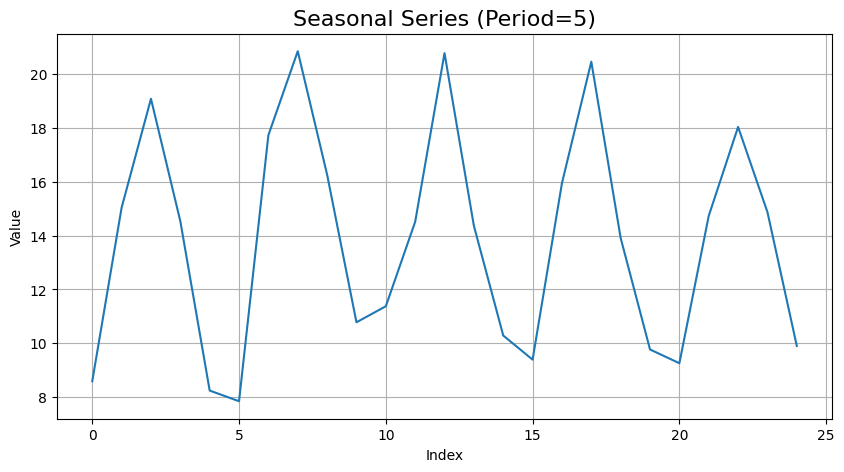

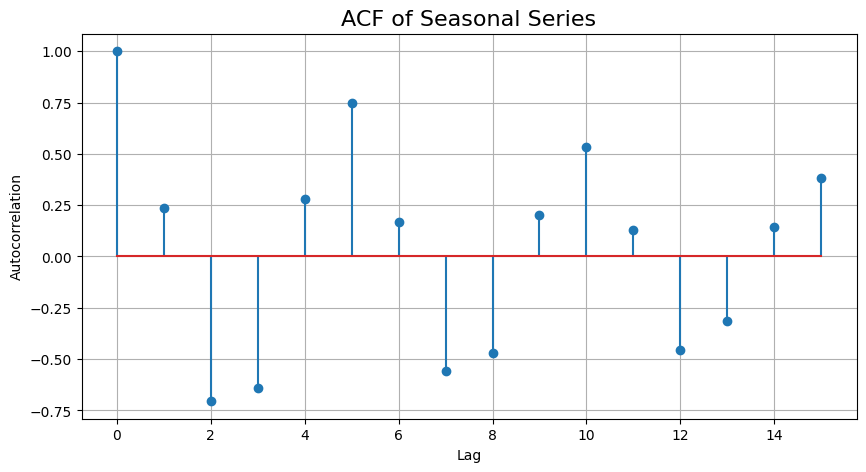

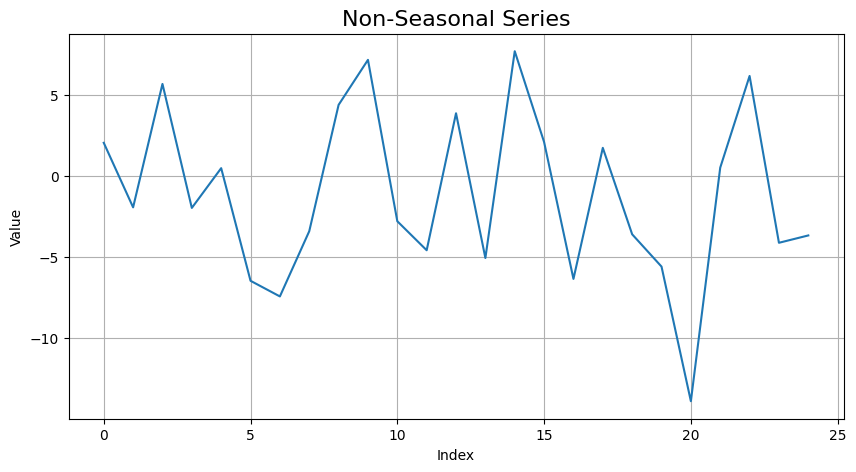

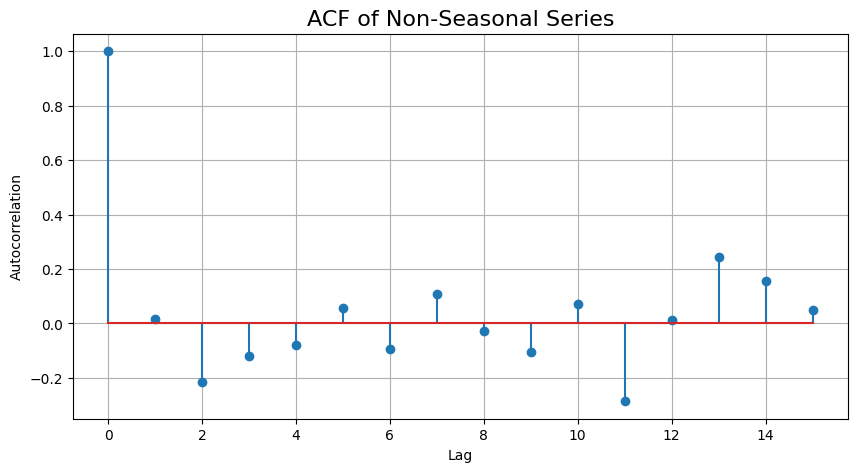

In [ ]:
# --- Test Case 1: Seasonal Series ---
# Create a small series with a strong seasonal pattern (period = 5)
seasonal_period = 5
seasonal_series = pd.Series(np.tile([10, 15, 20, 15, 10], 5) + np.random.normal(0, 1, 25))

# Plot the series
plt.figure(figsize=(10, 5))
plt.plot(seasonal_series)
plt.title('Seasonal Series (Period=5)', fontsize=16)
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
# plt.savefig('seasonal_series_plot.png')

# Plot the ACF to visualize the seasonality
plt.figure(figsize=(10, 5))
plt.stem(range(len(acf(seasonal_series, nlags=15))), acf(seasonal_series, nlags=15))
plt.title('ACF of Seasonal Series', fontsize=16)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
# plt.savefig('seasonal_acf_plot.png')

# --- Test Case 2: Non-Seasonal Series ---
# Create a small, random series
non_seasonal_series = pd.Series(np.random.normal(0, 5, 25))

# Plot the series
plt.figure(figsize=(10, 5))
plt.plot(non_seasonal_series)
plt.title('Non-Seasonal Series', fontsize=16)
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
# plt.savefig('non_seasonal_series_plot.png')

# Plot the ACF to visualize no seasonality
plt.figure(figsize=(10, 5))
plt.stem(range(len(acf(non_seasonal_series, nlags=15))), acf(non_seasonal_series, nlags=15))
plt.title('ACF of Non-Seasonal Series', fontsize=16)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
# plt.savefig('non_seasonal_acf_plot.png')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

def find_seasonal_period(series: pd.Series, max_lags: int = 50) -> int | None:
    """
    Finds the most likely seasonal period by checking for the highest
    statistically significant autocorrelation.

    Args:
        series (pd.Series): The input time series.
        max_lags (int): The maximum lag to check for a seasonal pattern.

    Returns:
        int: The detected seasonal period, or None if no strong seasonality is found.
    """
    if len(series) < 2 * max_lags:
        max_lags = len(series) // 2
    
    acf_values, conf_int = acf(series, nlags=max_lags, alpha=0.05)
    
    # Check for significant peaks beyond lag 0
    significant_lags = [
        i for i in range(1, len(acf_values)) 
        if abs(acf_values[i]) > (conf_int[i][1] - acf_values[i])
    ]
    
    if not significant_lags:
        return None
        
    # Find the lag with the highest absolute autocorrelation value
    peak_lag = significant_lags[0]
    for lag in significant_lags:
        if abs(acf_values[lag]) > abs(acf_values[peak_lag]):
            peak_lag = lag
            
    # Check if the highest peak is strong enough to be considered a dominant seasonal pattern
    if abs(acf_values[peak_lag]) < 0.3:  # A common heuristic for a strong signal
        return None
        
    return peak_lag

def has_strong_seasonality(series: pd.Series, seasonal_period: int, threshold: float = 0.5) -> bool:
    """
    Checks if a time series has strong seasonality at a given period.
    Returns True if a strong and significant seasonal pattern is detected.
    """
    if len(series) < seasonal_period * 2:
        return False
    
    acf_values, conf_int = acf(series, nlags=seasonal_period * 2, alpha=0.05)
    
    seasonal_acf = acf_values[seasonal_period]
    is_significant = abs(seasonal_acf) > (conf_int[seasonal_period][1] - acf_values[seasonal_period])
    is_strong = abs(seasonal_acf) > threshold
    
    return is_significant and is_strong

# --- Full Example ---
# Generate a series with a hidden seasonal period of 7
np.random.seed(42)
seasonal_period = 7
data = np.tile(np.arange(seasonal_period), 10) + np.random.normal(0, 0.5, 70)
series = pd.Series(data)

# Discover the seasonal period
discovered_period = find_seasonal_period(series)

print(f"Discovered seasonal period: {discovered_period}")

# Now, use the discovered period to verify if it has strong seasonality
if discovered_period:
    has_seasonality = has_strong_seasonality(series, discovered_period)
    print(f"Does the series have strong seasonality at the discovered period? {has_seasonality}")

Discovered seasonal period: 7
Does the series have strong seasonality at the discovered period? True


In [20]:
# Discover the seasonal period
discovered_period = find_seasonal_period(london_row)

print(f"Discovered seasonal period: {discovered_period}")

# Now, use the discovered period to verify if it has strong seasonality
if discovered_period:
    has_seasonality = has_strong_seasonality(london_row, discovered_period)
    print(f"Does the series have strong seasonality at the discovered period? {has_seasonality}")

Discovered seasonal period: 1
Does the series have strong seasonality at the discovered period? True


In [21]:
# Discover the seasonal period
discovered_period = find_seasonal_period(m4_row)

print(f"Discovered seasonal period: {discovered_period}")

# Now, use the discovered period to verify if it has strong seasonality
if discovered_period:
    has_seasonality = has_strong_seasonality(m4_row, discovered_period)
    print(f"Does the series have strong seasonality at the discovered period? {has_seasonality}")

Discovered seasonal period: 1
Does the series have strong seasonality at the discovered period? True


In [24]:
import numpy as np
import pandas as pd
from hurst import compute_Hc

# --- Series with Long-Term Memory (H > 0.5) ---
# This is a fractional Gaussian noise series, a type of fractional Brownian motion
# It's generated to have long-term dependencies.
# A true fractional Brownian motion can be complex to generate, so we simulate
# a process with memory for demonstration.
np.random.seed(42)
series_with_memory = np.cumsum(np.random.normal(0, 1, 1000) * 1.5 + np.sin(np.linspace(0, 4*np.pi, 1000)))
series_with_memory = pd.Series(series_with_memory)

# Calculate Hurst Exponent for the series with memory
H_memory, c, data = compute_Hc(series_with_memory)

print("--- Test Case 1: Series with Long-Term Memory ---")
print(f"Hurst Exponent (H): {H_memory:.4f}")
print("Interpretation: H > 0.5, indicating long-term memory or persistence.")
print("-" * 50)

# --- Series with No Memory (H approx. 0.5) ---
# A simple random walk, where each step is independent of the previous one.
np.random.seed(123)
random_walk = pd.Series(np.cumsum(np.random.normal(0, 1, 1000)))

# Calculate Hurst Exponent for the random walk
H_random_walk, c, data = compute_Hc(random_walk)

print("--- Test Case 2: Random Walk ---")
print(f"Hurst Exponent (H): {H_random_walk:.4f}")
print("Interpretation: H ≈ 0.5, indicating a series with no long-term memory.")
print("-" * 50)

--- Test Case 1: Series with Long-Term Memory ---
Hurst Exponent (H): 0.6969
Interpretation: H > 0.5, indicating long-term memory or persistence.
--------------------------------------------------
--- Test Case 2: Random Walk ---
Hurst Exponent (H): 0.5496
Interpretation: H ≈ 0.5, indicating a series with no long-term memory.
--------------------------------------------------


In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def classify_series(series: pd.Series, alpha: float = 0.05) -> str:
    """
    Classifies a time series based on a comparison of ADF test p-values.
    
    Args:
        series (pd.Series): The time series to classify.
        alpha (float): The significance level for the ADF test.
        
    Returns:
        str: The classified type ('change', 'random_walk', 'price'), or 'unknown'.
    """
    if series.isnull().any():
        series = series.dropna()

    # Test 1: Check for 'change' (stationary)
    try:
        if adfuller(series)[1] <= alpha:
            return 'change'
    except:
        return 'unknown'

    # Test 2: Compare random walk vs. price
    diff_p_value = 1.0
    log_diff_p_value = 1.0
    
    try:
        diff_p_value = adfuller(series.diff().dropna())[1]
    except:
        pass

    try:
        if (series > 0).all():  # Log requires positive values
            log_diff_p_value = adfuller(np.log(series).diff().dropna())[1]
    except:
        pass
    
    # Compare p-values to find the better fit
    print(f'diff_p_value: {diff_p_value}, log_diff_p_value: {log_diff_p_value}')
    if diff_p_value <= alpha and log_diff_p_value <= alpha:
        return 'random_walk' if diff_p_value < log_diff_p_value else 'price'
    elif diff_p_value <= alpha:
        return 'random_walk'
    elif log_diff_p_value <= alpha:
        return 'price'
    
    return 'unknown'

# --- Example Usage with Generated Series ---
# 1. 'change' series: a simple stationary series
change_series = pd.Series(np.random.normal(loc=1, scale=0.5, size=100))
print(f"Classification for 'change' series: {classify_series(change_series)}")

# 2. 'random_walk' series: cumulative sum of random increments
random_walk_series = change_series.cumsum()
print(f"Classification for 'random_walk' series: {classify_series(random_walk_series)}")

# 3. 'price' series: cumulative product of random multipliers
# We'll use the exp of a random walk to simulate this
price_series = np.exp(random_walk_series)
print(f"Classification for 'price' series: {classify_series(price_series)}")

Classification for 'change' series: change
diff_p_value: 0.00014395822482034327, log_diff_p_value: 1.617305241556072e-05
Classification for 'random_walk' series: price
diff_p_value: 1.0, log_diff_p_value: 0.00014395822482034327
Classification for 'price' series: price


In [39]:
kind = classify_series(london_row)
print(f"Classification for london series: {kind}")
H_memory, c, data = compute_Hc(london_row, kind=kind)
print(f"London Row Hurst Exponent (H): {H_memory:.4f}")
if H_memory > 0.5:
    print("Interpretation: H > 0.5, indicating long-term memory or persistence.")
else:
    print("Interpretation: H < 0.5, indicating no long-term memory.")
print("-" * 50)

kind = classify_series(m4_row)
print(f"Classification for m4 series: {kind}")
H_memory, c, data = compute_Hc(m4_row, kind=kind)
print(f"M4 Row Hurst Exponent (H): {H_memory:.4f}")
if H_memory > 0.5:
    print("Interpretation: H > 0.5, indicating long-term memory or persistence.")
else:
    print("Interpretation: H < 0.5, indicating no long-term memory.")
print("-" * 50)

diff_p_value: 0.0, log_diff_p_value: 0.0
Classification for london series: price
London Row Hurst Exponent (H): 0.5169
Interpretation: H > 0.5, indicating long-term memory or persistence.
--------------------------------------------------
diff_p_value: 4.126917156375488e-27, log_diff_p_value: 5.196425485448155e-27
Classification for m4 series: random_walk
M4 Row Hurst Exponent (H): 0.4968
Interpretation: H < 0.5, indicating no long-term memory.
--------------------------------------------------
